In [1]:
box = 'Box_n50_0_1400'


In [2]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools

ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

def M_to_R(M, box, a):
    """
    Converts mass of top-hat filter to radius of top-hat filter
    
    Parameters:
        - M (float): Mass of the top hat filter in units Msolor/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - R (float): Corresponding radius of top hat filter Mpc/h
    """

    return (M / (4/3 * math.pi * rhom_a(box, a))) ** (1/3) # h^-1 Mpc  

def R_to_M(R,box, a):
    """
    Converts radius of top-hat filter to mass of top-hat filter
    
    Parameters:
        - R (float): Radius of the top hat filter in units Mpc/h
        - box (string): Which Aemulus nu box we're considering 
        - a (float): Redshift 

    Returns:
        - M (float): Corresponding mass of top hat filter Msolar/h 
    """
    return R ** 3 * 4/3 * math.pi * rhom_a(box, a)

def scaleToRedshift(a):
    return 1/a-1

def redshiftToScale(z):
    return 1/(1+z)

@functools.cache
def sigma2(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes variance of mass fluctuations with top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc

    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - sigma2 (float): The variance of mass fluctuations
    """

    def dσ2dk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dσ2dk = W**2 * pk(k) * k**2 / 2 / np.pi**2
        return dσ2dk
    res, err = quad(dσ2dk, 0, np.inf)
    σ2 = res
    return σ2

def rhom_a(box, a):
    ombh2 = cosmo_params[box]['ombh2']
    omch2 = cosmo_params[box]['omch2']
    H0 = cosmo_params[box]['H0'] #[km s^-1 Mpc-1]
    h = H0/100 

    Ωm = ombh2/h**2 + omch2/h**2
    
    ΩDE = 1 - Ωm
    wDE = cosmo_params[box]['w0'] #'wa' is zero for us

    return Ωm*ρcrit0#*(Ωm*a**(-3) + ΩDE*a**(-3*(1+wDE))) * a**3 # h^2 Msol/Mpc^3
    
@functools.cache
def dsigma2dR(pk, R):
    """
    Adapated from https://github.com/komatsu5147/MatterPower.jl
    Computes deriative of variance of mass fluctuations wrt top hat filter of radius R
    For this function let k be the comoving wave number with units h/Mpc
    
    Parameters:
        - pk (funtion): P(k), the matter power spectrum which has units Mpc^3 / h^3
        - R (float): The smoothing scale in units Mpc/h
    Returns:
        - dsigma2dR (float): The derivative of the variance of mass fluctuations wrt R
    """

    def dσ2dRdk(k):
        x = k * R
        W = (3 / x) * (np.sin(x) / x**2 - np.cos(x) / x)
        dWdx = (-3 / x) * ((3 / x**2 - 1) * np.sin(x) / x - 3 * np.cos(x) / x**2)
        dσ2dRdk = 2 * W * dWdx * pk(k) * k**3 / 2 / np.pi**2
        return dσ2dRdk
    res, err = quad(dσ2dRdk, 0, np.inf)
    return res

def dRdM(M, box, a):
    return 1/(6**(2/3)*np.pi**(1/3)*M**(2/3)*rhom_a(box, a)**(1/3))

In [3]:
def get_mass_function_plots(yerr_dict, params):
        i=0
        fig_axs = {}
        for a in N_data:

            z = a_to_z[a]
            fig1 = plt.figure(figsize =(12, 7))

            axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
            plt.subplots_adjust(wspace=0, hspace=0)
            Pk = Pkz[z]
            c_data = NvMs[a]

            Ms = M_data[a]
            N = N_data[a]
            edge_pairs = c_data['edge_pairs']

            edges = [edge[0] for edge in edge_pairs]
            edges += [edge_pairs[-1][1]]

            yerr = yerr_dict[a]
            dM = np.array([edges[1]-edges[0] for edges in edge_pairs])
            
            
            tinker_eval_MCMC = [tinker(a, M_c,**params,)*vol for M_c in M_numerics]
#             print(tinker_eval_MCMC)

#             f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)
#             f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
            f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)

            tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])
            color = plt.colormaps["rainbow"]((i+1)/len(Pkz.keys()))[:-1]



            axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')
            axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')

            edges = np.array(edges)
            axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
                       align='edge', fill=False, ec='black', label='Data')
            axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), align='edge', fill=False, ec='blue', label='Tinker')
            axs[1].errorbar(Ms, (tinker_eval_MCMC-N), yerr, fmt='x', color='blue')

            y1 = 0.1*np.array(N)
            y1 = np.append(y1, y1[-1])
            y1 = np.append(y1[0], y1)

            y2 = -0.1*np.array(N)
            y2 = np.append(y2, y2[-1])
            y2 = np.append(y2[0], y2)

            c_Ms = np.append(Ms, edges[-1])
            c_Ms = np.append(edges[0], c_Ms)
            axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

            y1 = 0.01*np.array(N)
            y1 = np.append(y1, y1[-1])
            y1 = np.append(y1[0], y1)

            y2 = -0.01*np.array(N)
            y2 = np.append(y2, y2[-1])
            y2 = np.append(y2[0], y2)

            axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


            axs[0].set_xscale('log')
            axs[0].set_yscale('log')
            axs[0].legend(frameon=False)
            axs[0].set_ylabel('N')

            axs[1].set_xscale('log')
            axs[1].set_yscale('symlog', linthresh=1)    
            axs[1].legend(frameon=False)
            axs[1].axhline(0, c='black')
            axs[1].set_ylabel('N')
            axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
            axs[1].set_ylabel(r'${N_{\rm Tinker}-N_{\rm data}} $')
            axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, a_to_z[a]))
            i+=1

            axs[0].set_xlim((200*Mpart, np.max(edges)))
            axs[1].set_xlim((200*Mpart, np.max(edges)))
            fig_axs[a] = [fig1, axs]
        return fig_axs

In [4]:
base_dir = '/home/users/delon/aemulus_nu/'


import numpy as np
cosmos = {}

tier1_fname = base_dir+'tier1_cosmos.txt'
f = open(tier1_fname, 'r')
columns = [col[:-1] for col in f.readline().strip().split()[1:]]
print(columns)
i = 0
for line in f:
    box_name = 'Box%d_1400'%(i)
    assert(len(line.split()) == len(columns))
    cosmos[box_name] = dict(zip(columns, np.array(line.split(), dtype=np.float64)))
    i+=1
f.close()


tier2_fname = base_dir+'tier2_cosmos.txt'
f = open(tier2_fname, 'r')
columns = [col[:-1] for col in f.readline().strip().split()[1:]]
print(columns)
i = 0
for line in f:
    box_name = 'Box_n50_%d_1400'%(i)
    assert(len(line.split()) == len(columns))
    cosmos[box_name] = dict(zip(columns, np.array(line.split(), dtype=np.float64)))
    i+=1
f.close()

['As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma']
['As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma']


In [5]:
from tqdm import tqdm, trange
from classy import Class
import pickle


key = box

cosmo = cosmos[key]
h = cosmo['H0']/100
cosmo_dict = {
    'h': h,
    'Omega_b': cosmo['ombh2'] / h**2,
    'Omega_cdm': cosmo['omch2'] / h**2,
    'N_ur': 0.00641,
    'N_ncdm': 1,
    'output': 'mPk mTk',
    'z_pk': '0.0,99',
    'P_k_max_h/Mpc': 20.,
    'm_ncdm': cosmo['nu_mass_ev']/3,
    'deg_ncdm': 3,
    'T_cmb': 2.7255,
    'A_s': cosmo['As'] * 10**-9,
    'n_s': cosmo['ns'],
    'Omega_Lambda': 0.0,
    'w0_fld': cosmo['w0'],
    'wa_fld': 0.0,
    'cs2_fld': 1.0,
    'fluid_equation_of_state': "CLP"
}
pkclass = Class()
pkclass.set(cosmo_dict)
pkclass.compute()

curr_run_fname = '/oak/stanford/orgs/kipac/aemulus/aemulus_nu/%s/'%(key)
rockstar_dir = curr_run_fname+'output/rockstar/'

f = open(rockstar_dir+'savelist.txt', 'r')
savelist = f.read().split()
f.close()

N_snapshots = len(savelist)
a = []
for i in range(N_snapshots):
    f = open(rockstar_dir+'out_%d.list'%(i), 'r')

    for line in f:
        if('#a' in line):
            a+= [eval(line.split()[2])]
            break


zs = [scaleToRedshift(a_curr) for a_curr in a]

Pkz = {}
for z in  zs:
    kt = np.logspace(-3, 1, 100) # h/Mpc
    pk_m_lin = np.array(
        [
            pkclass.pk_lin(ki, np.array([z]))*h**3 #units of Mpc^3/h^3
            for ki in kt * h # 1 / Mpc
        ]
    )
    from scipy.interpolate import interp1d
    #given k in units of h/Mpc gives Pk in units of Mpc^3/h^3 
    Pk = interp1d(kt, pk_m_lin, kind='linear', bounds_error=False, fill_value=0.)

    Pkz[z] = Pk    
    class_sigma8 = pkclass.sigma(8, z, h_units=True)
    my_sigma8 = np.sqrt(sigma2(Pk, 8)) # 8 h^-1 Mpc
#         print(class_sigma8, my_sigma8)
    assert(np.abs(class_sigma8-my_sigma8)<0.01*class_sigma8)
#         plt.plot(kt, Pk(kt))
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.show()



/tmp/ipykernel_9249/1165743667.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


In [6]:
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm, trange
import seaborn
import matplotlib.pyplot as plt
import os
import emcee
import sys
import numpy as np
import pickle

In [7]:
cosmos_f = open('data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

In [8]:

h = cosmo_params[box]['H0']/100

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

#deal with floating point errors
a_to_z = dict(zip(NvMs.keys(), Pkz.keys()))
z_to_a = dict(zip(Pkz.keys(), NvMs.keys()))

In [9]:
N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

dlnσinvdMs = {}

vol = -1 #Mpc^3/h^3
Mpart = -1

for z in tqdm(Pkz.keys()):
    a = z_to_a[z]
#     if(a not in LOOKING_AT):
#         continue
    Pk = Pkz[z]
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    M_numerics = np.logspace(np.log10(100*Mpart), 17, 200) #h^-1 Msolar
    
    
    R = [M_to_R(m, box, a) for m in M_numerics] #h^-1 Mpc
    
    
    sigma2s = np.array([sigma2(Pk, r) for r in R])
    sigma = np.sqrt(sigma2s)
    ds2dR = np.array([dsigma2dR(Pk, r) for r in R])
    dRdMs = np.array([dRdM(m, box, a) for m in M_numerics])
    ds2dM = ds2dR * dRdMs
    dlnsinvds2 = -1/(2*sigma2s)
    dlnsinvdM = ds2dM*dlnsinvds2
    
    f_dlnsinvdM_log = interp1d(np.log10(M_numerics), dlnsinvdM, kind='cubic')
    f_dlnsinvdM = lambda x:f_dlnsinvdM_log(np.log10(x))
    
    
    dlnσinvdMs[a] = f_dlnsinvdM    

  0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_9249/1165743667.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)
/tmp/ipykernel_9249/1165743667.py:102: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the 

In [10]:
from scipy.special import gamma
from scipy.optimize import curve_fit

def p(a, p0, p1):
    oup = (p0)+(a-0.5)*(p1)
    return oup

def B(a, M, σM, d, e, f, g):
    oup = e**(d)*g**(-d/2)*gamma(d/2)
    oup += g**(-f/2)*gamma(f/2)
    oup = 2/oup
    return oup
    
    
def f_G(a, M, σM, d, e, f, g):
    oup = B(a, M, σM, d, e, f, g)
    oup *= ((σM/e)**(-d)+σM**(-f))
    oup *= np.exp(-g/σM**2)
    return oup

def tinker(a, M, 
           d0, d1,
          e0, e1,
          f0, f1,
          g0,g1):
    d = p(a, d0, d1)
    e = p(a, e0, e1)
    f = p(a, f0, f1)
    g = p(a, g0, g1)
    
    R = M_to_R(M, box, a) #Mpc/h
    σM = np.sqrt(sigma2(Pkz[a_to_z[a]], R))  
    oup = f_G(a, M, σM, d, e, f, g)
    oup *= rhom_a(box, a)/M
    oup *= dlnσinvdMs[a](M)
    return oup

In [11]:
a_list = list(NvMs.keys())

from scipy.stats import poisson
param_names = [ 'd0', 'd1',
               'e0', 'e1',
               'f0', 'f1',
               'g0','g1']


M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

In [12]:
jack_covs = {a:jackknife[a][1] for a in N_data}

# poisson_err = {a:np.sqrt(N_data[a]) for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

# Inverse of the weighted covariance matrix
inv_weighted_cov = {a:np.linalg.inv(weighted_cov[a]) for a in weighted_cov}  

scale_cov = {a:np.log(np.linalg.det(weighted_cov[a])) for a in weighted_cov}

In [13]:
def log_prior(param_values):
    #uniform prior
    for param in param_values:
        if(np.abs(param) >= 5):
            return -np.inf
    for a in N_data:
        d = p(a, param_values[0], param_values[1])
        e = p(a, param_values[2], param_values[3])
        f = p(a, param_values[4], param_values[5])
        g = p(a, param_values[6], param_values[7])
        ps = [d,e,f,g]
        for param in ps:
            if(param < 0 or param > 5):
                return -np.inf
    return 0

def log_prob(param_values):   
    """
    Calculates the probability of the given tinker parameters 
    
    Args:
        param_values (np.ndarray): Input array of shape (number of params).
        
    Returns:
        float: Resulting log probability
    """

    if(log_prior(param_values) == -np.inf):
        return -np.inf
    
    params = dict(zip(param_names, param_values))
    tinker_fs = {}
    
    for a in N_data:
        tinker_eval = [tinker(a, M_c,**params,)*vol for M_c in M_numerics]
        f_dndlogM = interp1d(M_numerics, tinker_eval, kind='linear', bounds_error=False, fill_value=0.)
        tinker_fs[a] = f_dndlogM
        
    model_vals = {}
    for a in N_data:
        if(a_to_z[a] >=2):
#             print(1)
            continue
        model_vals[a] = np.array([quad(tinker_fs[a], edge_pair[0], edge_pair[1], epsabs=1e-1)[0]
            for edge_pair in NvMs[a]['edge_pairs']
        ])
    
    
    residuals = {a: model_vals[a]-N_data[a] for a in model_vals}
    log_probs = [ -0.5 * (np.dot(np.dot(residuals[a].T, inv_weighted_cov[a]), residuals[a]) + scale_cov[a]) 
                 for a in model_vals]
    if not np.isfinite(np.sum(log_probs)): 
        return -np.inf
    return np.sum(log_probs)

def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [14]:
guess = np.random.uniform(size=(len(param_names)))
while(not np.isfinite(log_likelihood(guess))):
    guess = np.random.uniform(size=(len(param_names)))


print('Starting ML Fit')
#Start by sampling with a maximum likelihood approach
from scipy import optimize as optimize
nll = lambda *args: -log_likelihood(*args)
result = optimize.minimize(nll, guess, method="Nelder-Mead", options={
    'maxiter': len(guess)*10000
})
result['param_names'] = param_names
print(box)
print(result)
print(result['x'])

/tmp/ipykernel_9249/1165743667.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, np.inf)


Starting ML Fit
Box_n50_0_1400
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 49335.834539609816
             x: [ 1.126e+00  5.162e-01  4.964e+00  7.169e-02  1.828e-01
                 -1.442e-02  1.108e+00  2.589e-01]
           nit: 1504
          nfev: 2223
 final_simplex: (array([[ 1.126e+00,  5.162e-01, ...,  1.108e+00,
                         2.589e-01],
                       [ 1.126e+00,  5.162e-01, ...,  1.108e+00,
                         2.589e-01],
                       ...,
                       [ 1.126e+00,  5.162e-01, ...,  1.108e+00,
                         2.589e-01],
                       [ 1.126e+00,  5.162e-01, ...,  1.108e+00,
                         2.589e-01]]), array([ 4.934e+04,  4.934e+04,  4.934e+04,  4.934e+04,
                        4.934e+04,  4.934e+04,  4.934e+04,  4.934e+04,
                        4.934e+04]))
   param_names: ['d0', 'd1', 'e0', 'e1', 'f0', 'f1', 'g0', 'g1']
[ 1.12592

In [15]:
MLE_params = dict(zip(param_names, result['x']))

In [16]:
# MLE_params = dict(zip(param_names, [ 1.559e+00, -2.079e+00,  1.077e+00,  4.308e+00,  1.358e+00,
#                   1.637e-01,  8.069e-01,  4.079e-01]))


/tmp/ipykernel_9249/3814696707.py:77: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
/tmp/ipykernel_9249/3814696707.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])


{0.25: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_0_1400, a=0.25, z=3.00'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='${N_{\\rm Tinker}-N_{\\rm data}} $'>]],
 0.302679: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_0_1400, a=0.30, z=2.30'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='${N_{\\rm Tinker}-N_{\\rm data}} $'>]],
 0.366459: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_0_1400, a=0.37, z=1.73'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='${N_{\\rm Tinker}-N_{\\rm data}} $'>]],
 0.403224: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_0_1400, a=0.40, z=1.48'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h^{-1}M_\\odot]$', ylabel='${N_{\\rm Tinker}-N_{\\rm data}} $'>]],
 0.488191: [<Figure size 864x504 with 2 Axes>,
  [<Axes: title={'center': 'Box_n50_0_1400, a=0.49, z=1.05'}, ylabel='N'>,
   <Axes: xlabel='Mass $[h

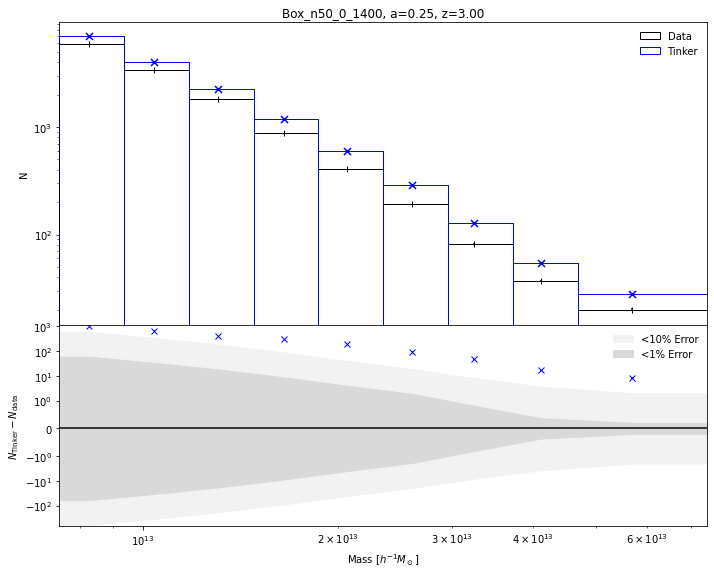

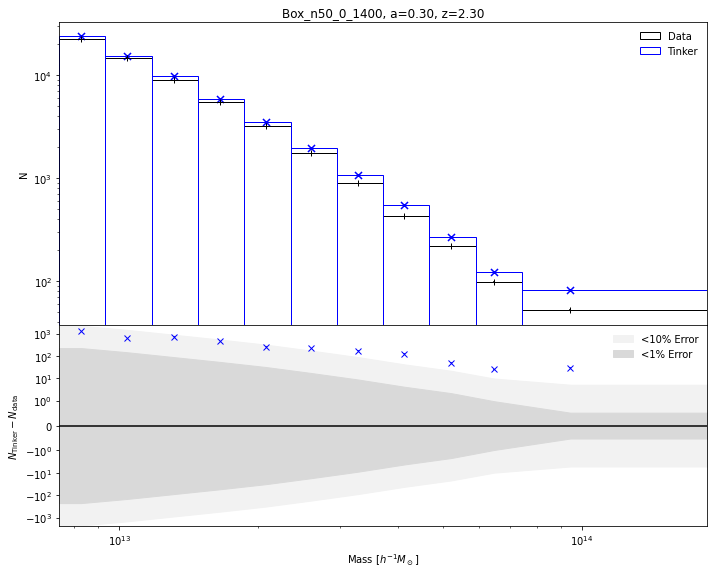

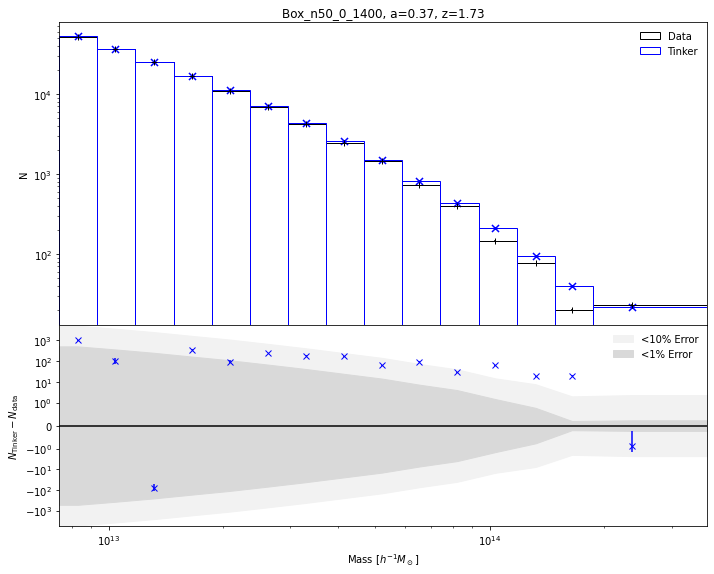

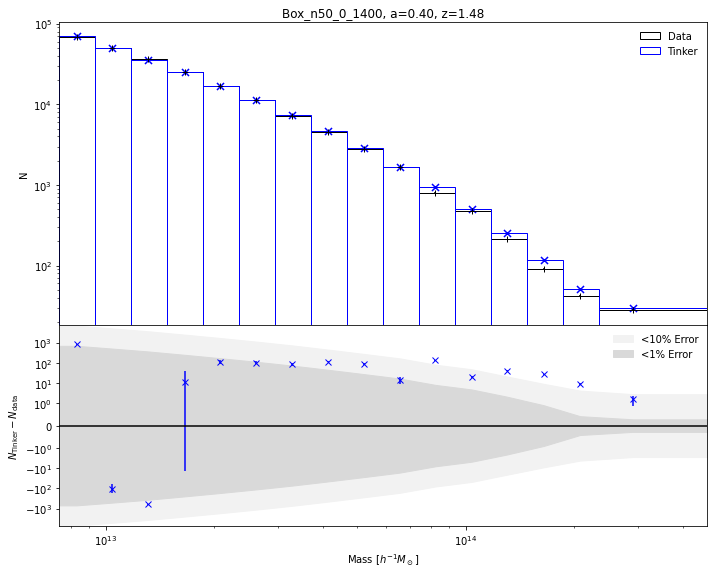

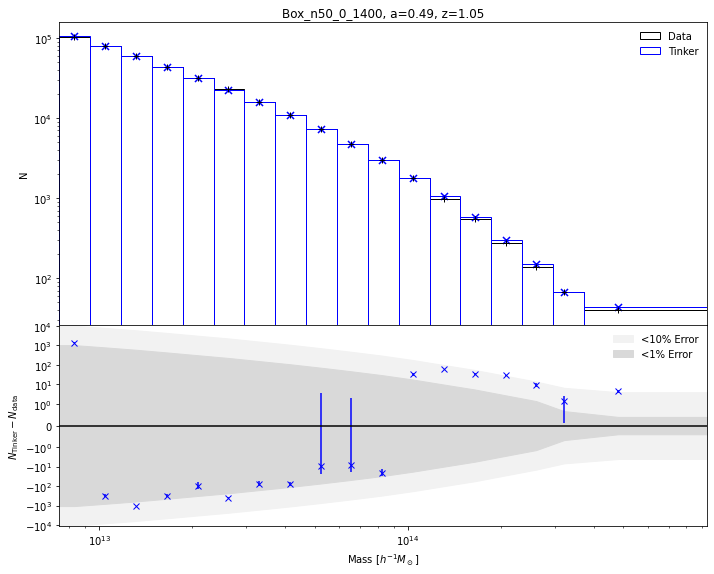

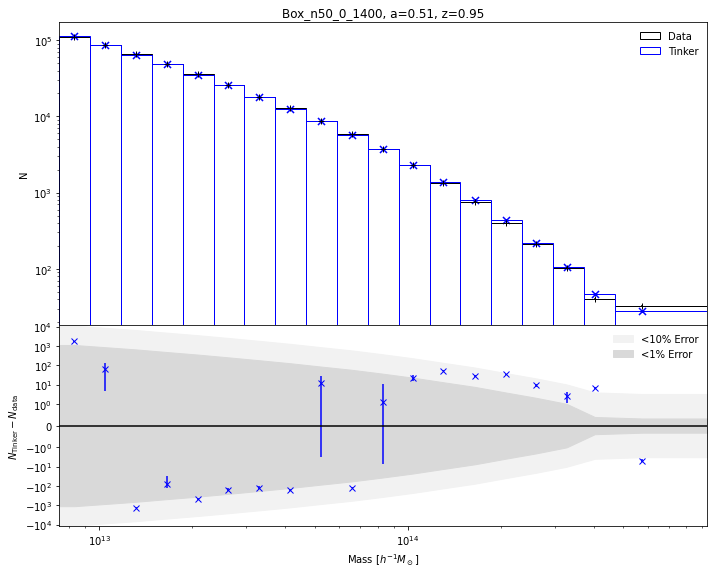

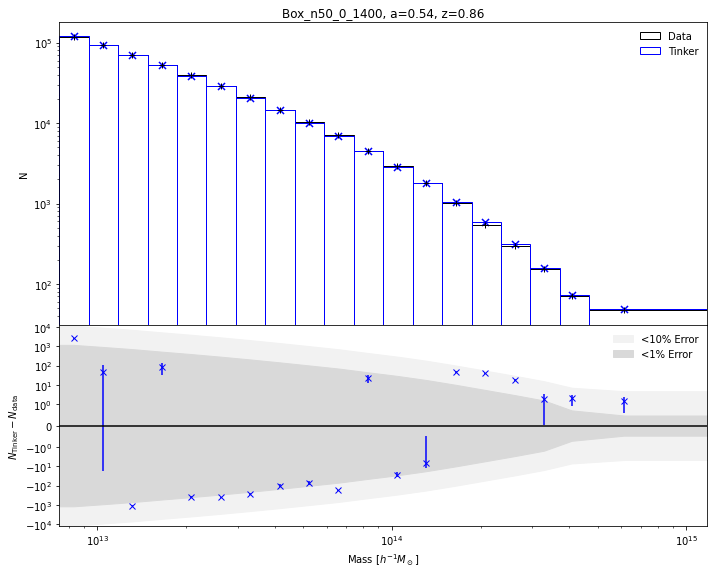

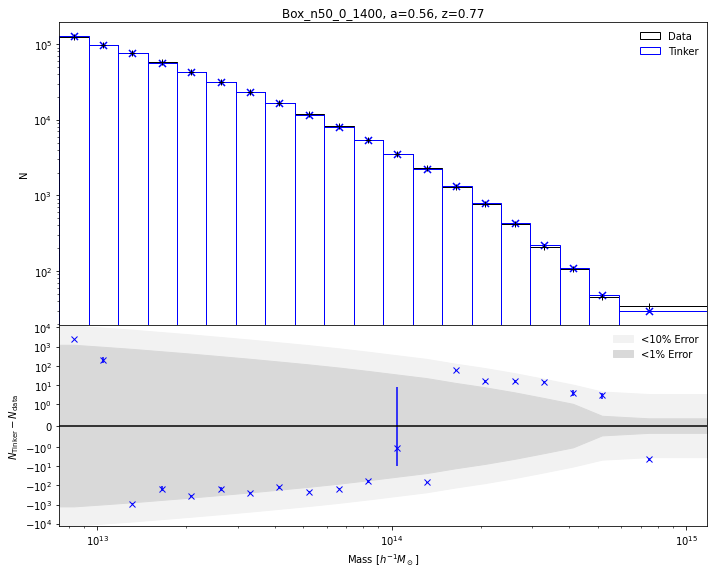

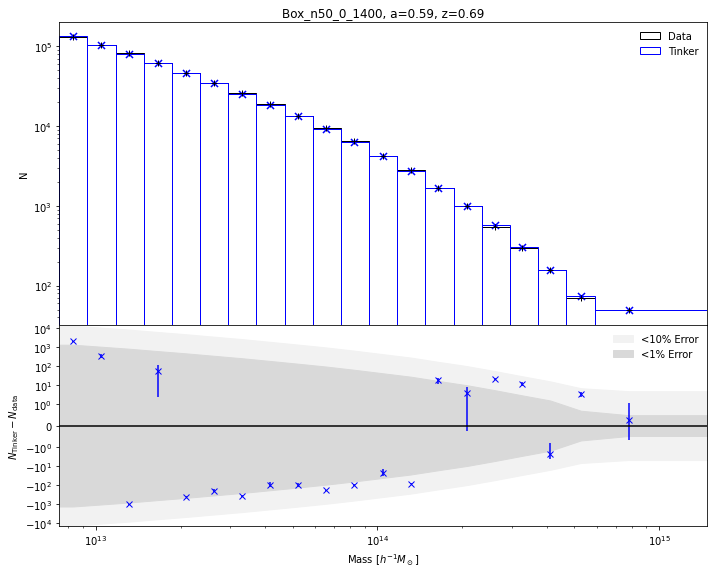

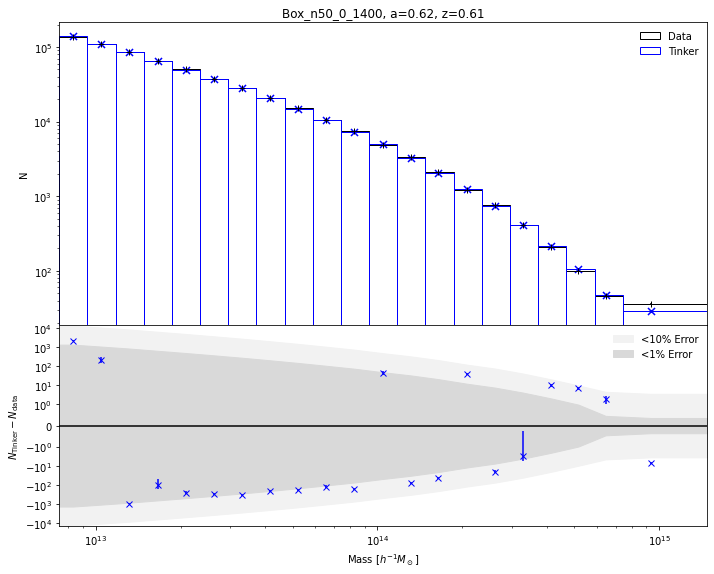

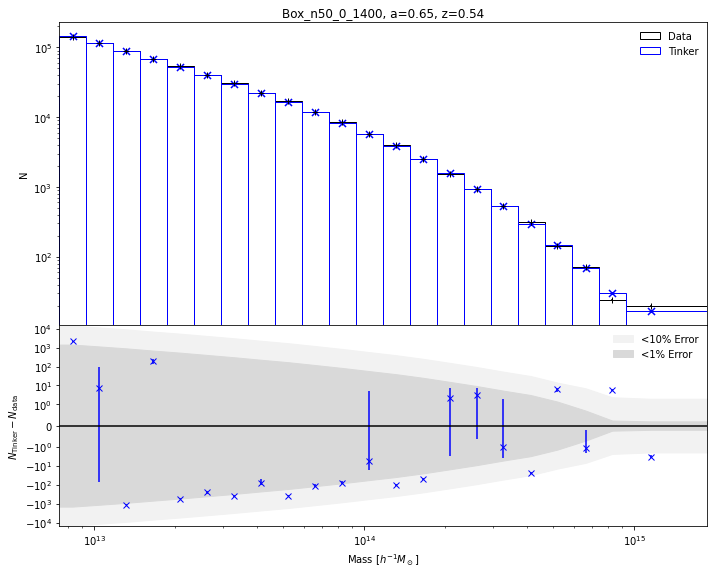

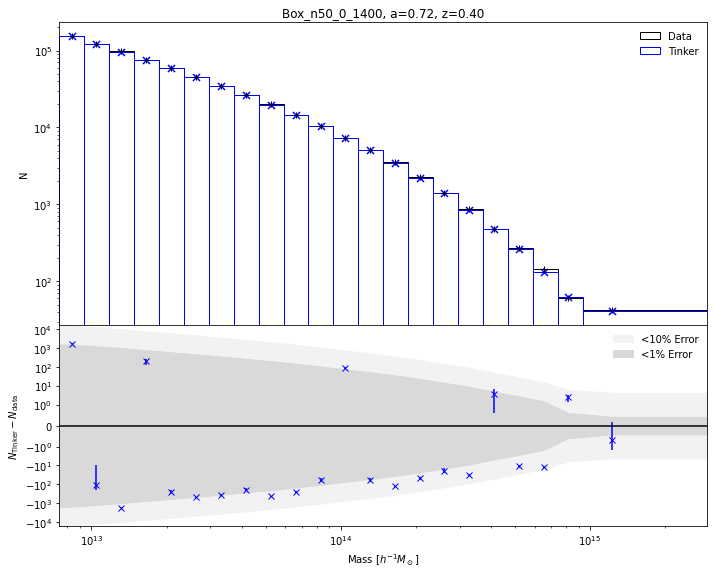

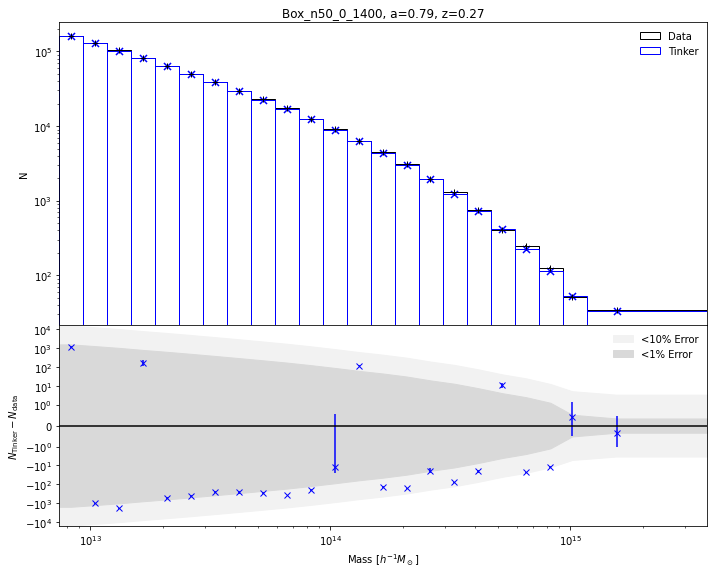

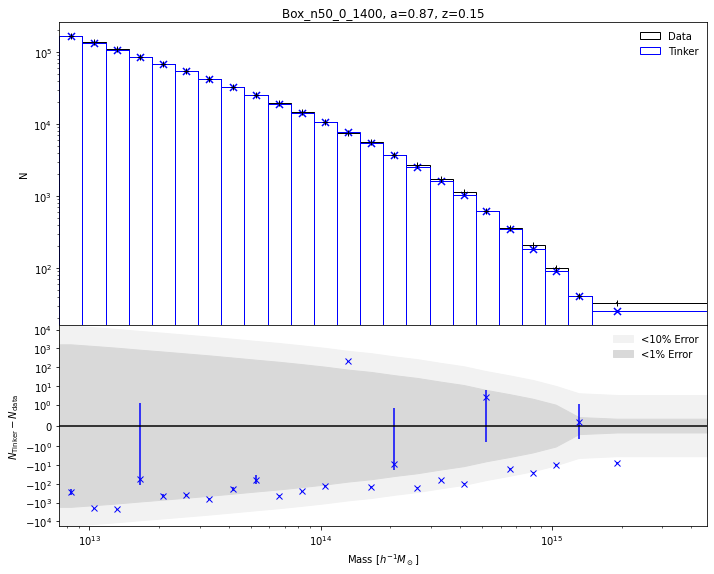

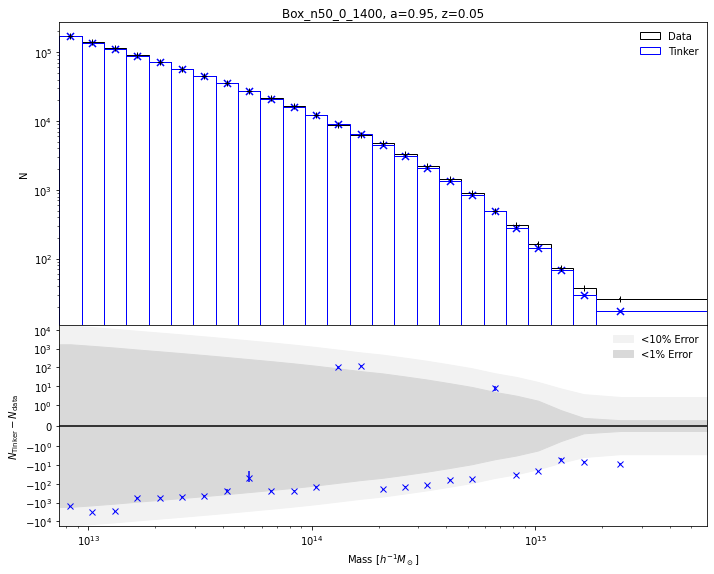

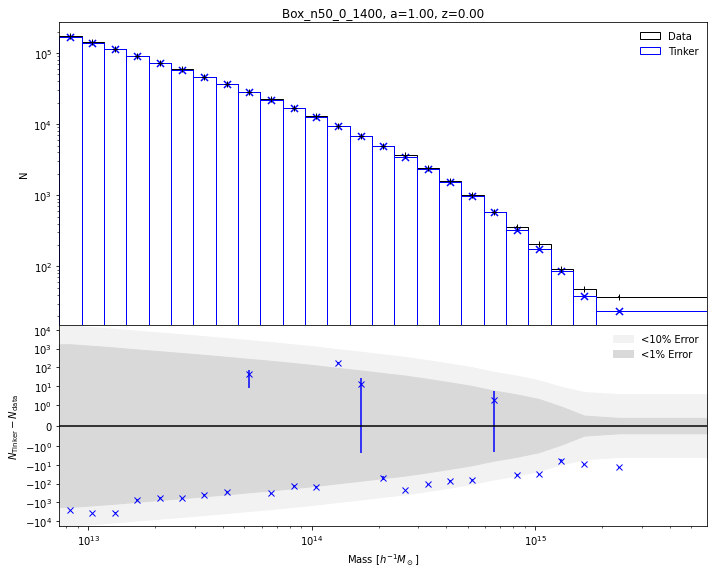

In [17]:
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
get_mass_function_plots(yerr_dict, MLE_params)

In [18]:
print(1)

1


In [19]:
result_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_MLFit.pkl'
result_f = open(result_fname, 'wb')
pickle.dump(result, result_f)
result_f.close()

In [20]:
nwalkers = 64
ndim = len(param_names)

initialpos = np.array([result['x'] for _ in range(nwalkers)]) + 1e-2 * np.random.normal(size=(nwalkers, ndim))


from multiprocessing import Pool

sampler = emcee.EnsembleSampler(
    nwalkers = nwalkers,
    ndim = ndim,
    log_prob_fn = log_likelihood,
    pool=Pool()
)

sampler.run_mcmc(initialpos, 1000, progress=True);

with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "wb") as f:
    pickle.dump(sampler, f)

  0%|          | 0/1000 [00:00<?, ?it/s]/oak/stanford/orgs/kipac/users/delon/miniconda3/envs/massfunction/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [26:24<00:00,  1.58s/it]


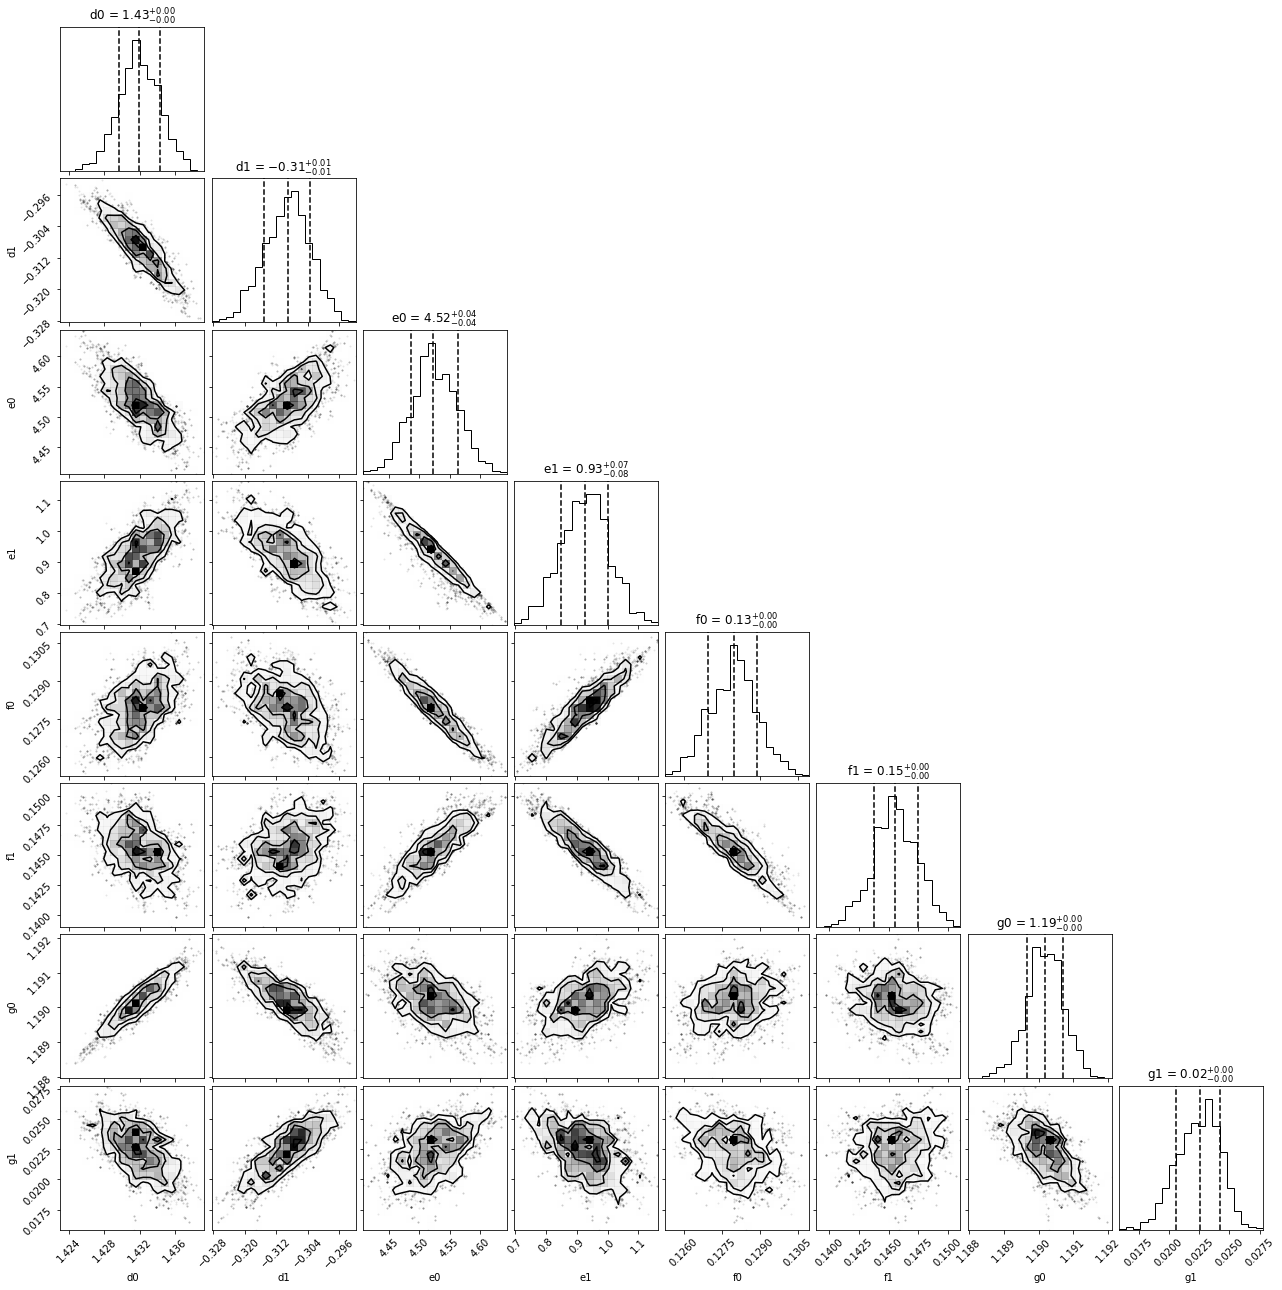

In [21]:
labels = param_names

import corner
samples = sampler.chain[:, 900:, :].reshape((-1, ndim))
final_param_vals = np.percentile(samples,  50,axis=0)
params_final = dict(zip(param_names, final_param_vals))
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True,)

plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_corner.pdf'%(box), bbox_inches='tight')

(1000, 64, 8)


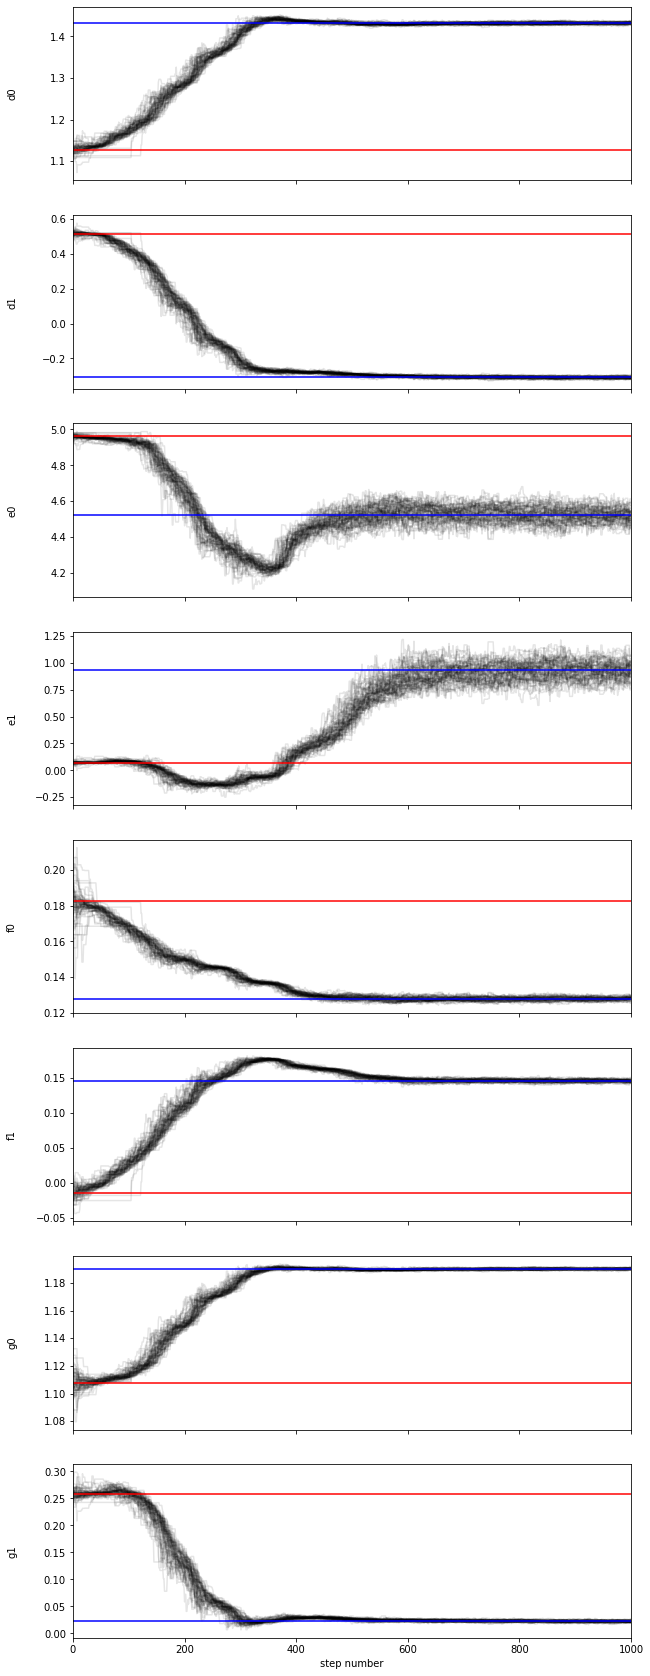

In [22]:
labels = param_names

fig, axes = plt.subplots(ndim, figsize=(10, 30), sharex=True)
samples = sampler.get_chain()
print(np.shape(samples))
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(result['x'][i], color='red')
    ax.axhline(final_param_vals[i], color='blue')
axes[-1].set_xlabel("step number");

plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_MCMC_convergence.pdf'%(box), bbox_inches='tight')

In [23]:
params_final

{'d0': 1.4318816124734002,
 'd1': -0.3089285041923153,
 'e0': 4.5231877423959945,
 'e1': 0.9280222017926353,
 'f0': 0.12798042240273427,
 'f1': 0.1455306793836951,
 'g0': 1.1901917666246355,
 'g1': 0.022536353651855096}

/tmp/ipykernel_9249/3814696707.py:77: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')
/tmp/ipykernel_9249/3814696707.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1])[0] for edge in edge_pairs])


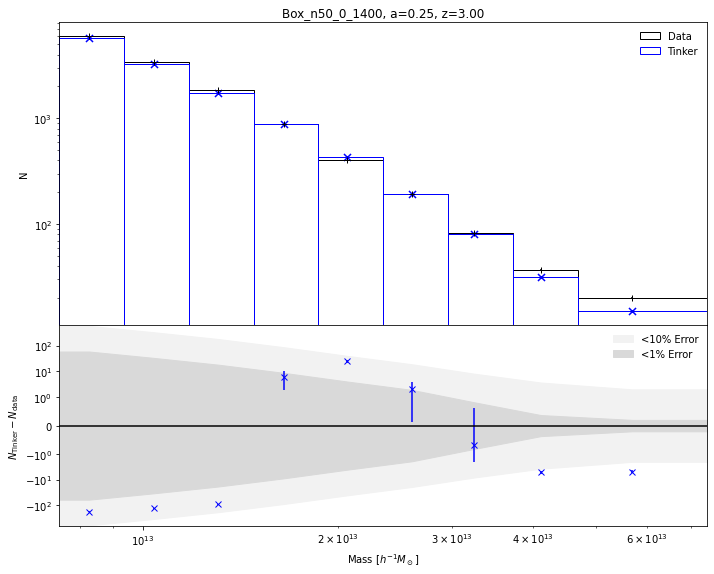

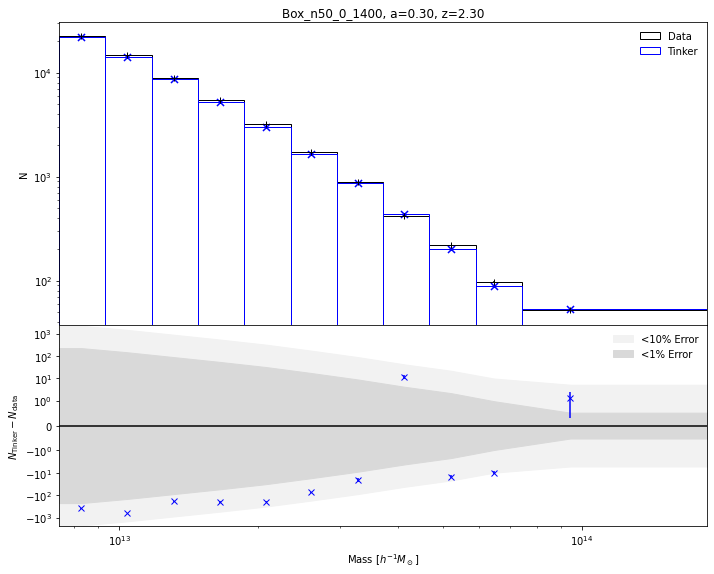

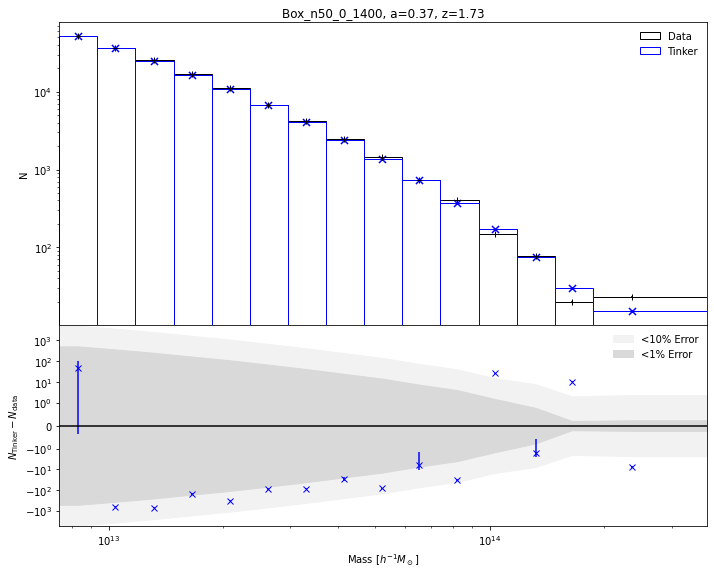

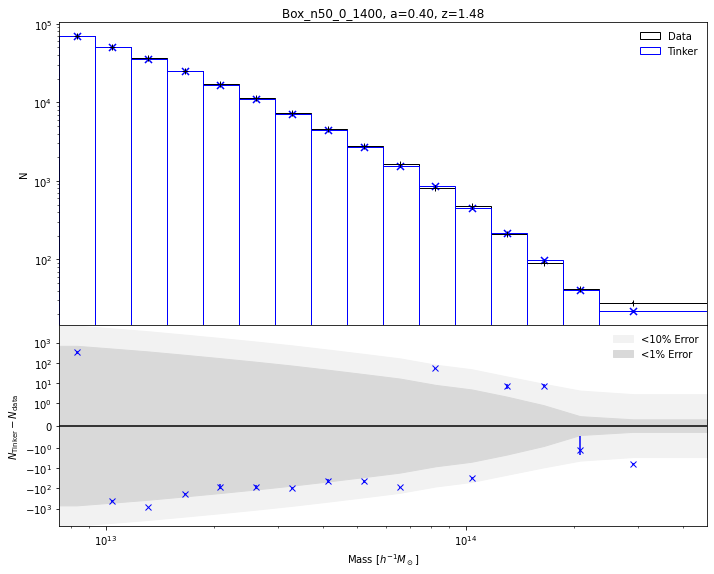

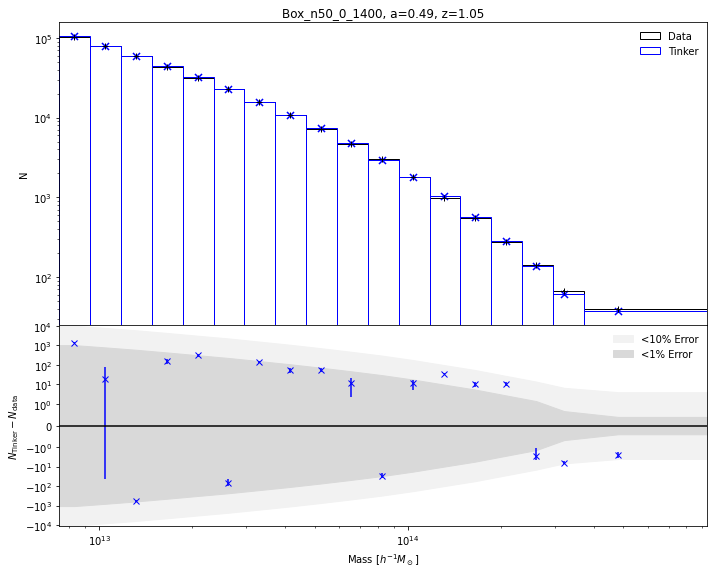

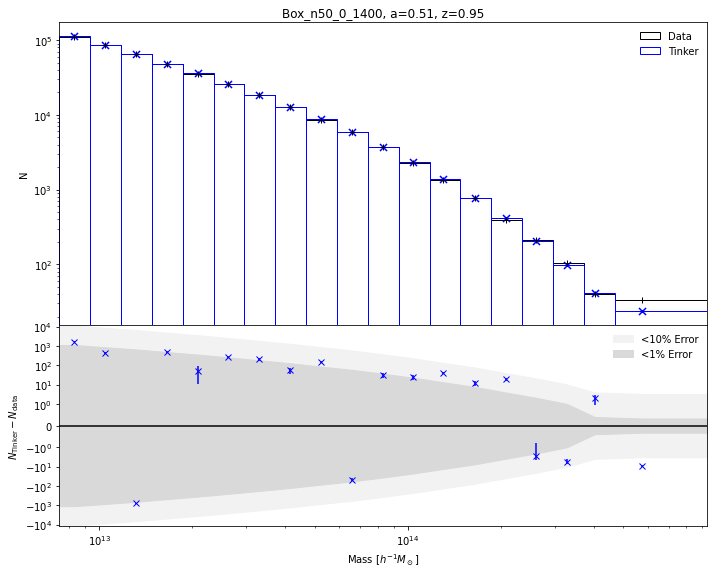

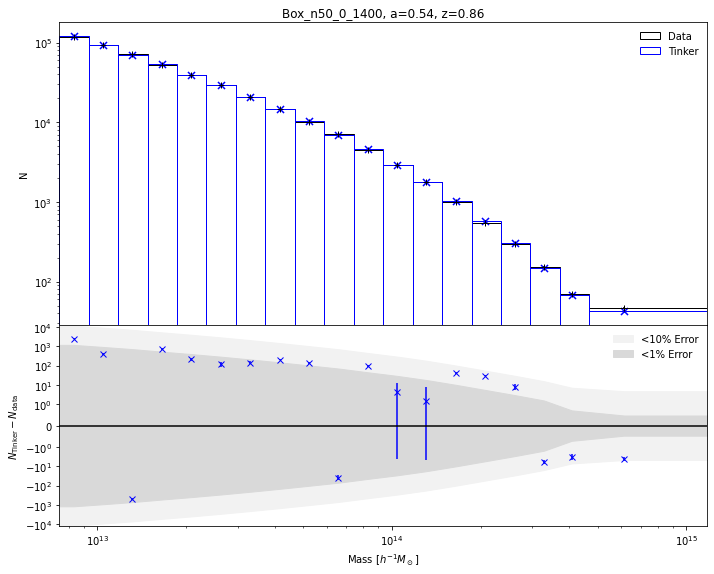

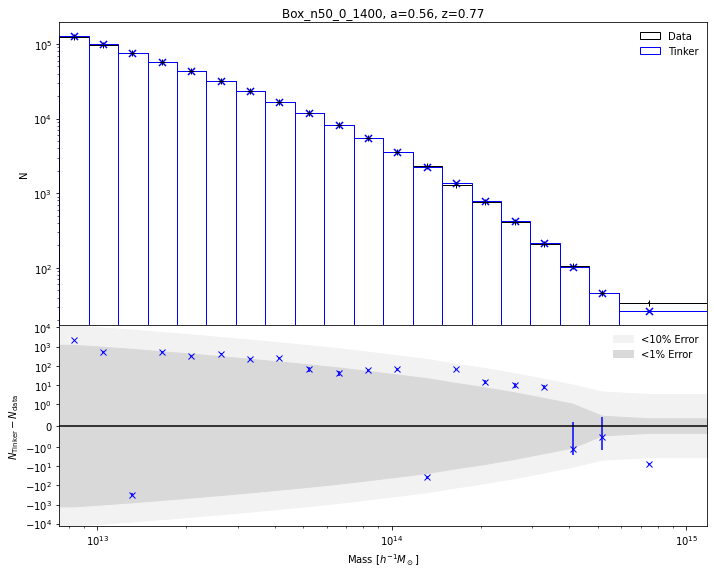

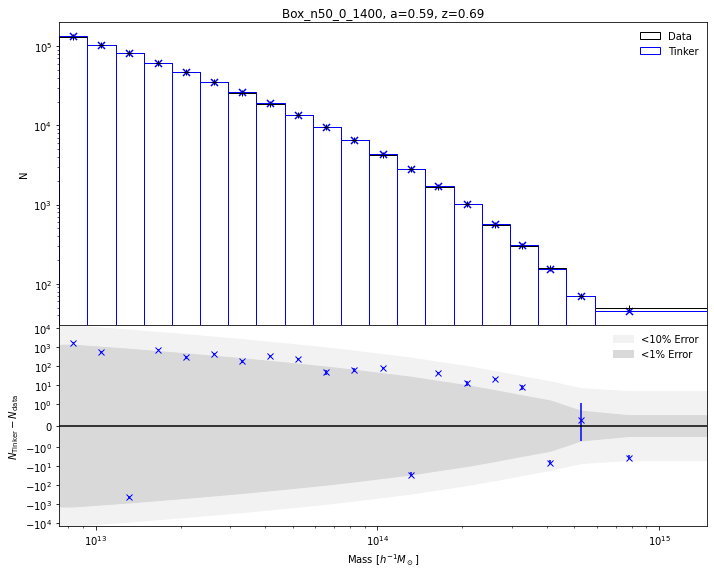

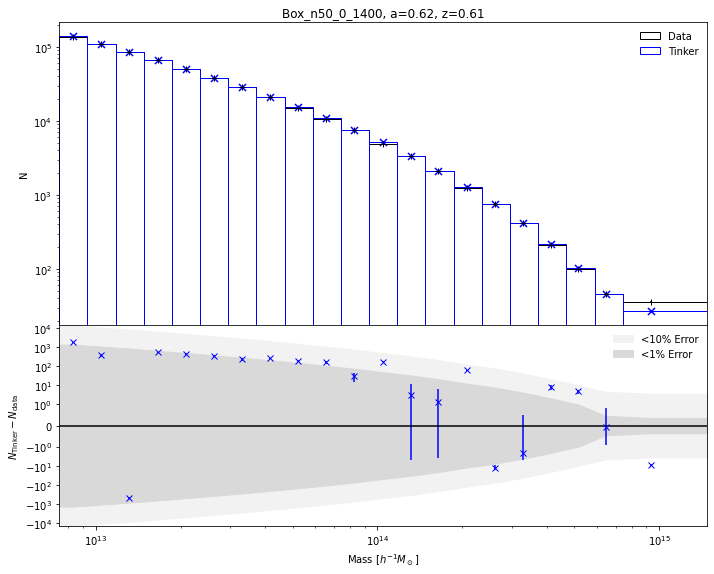

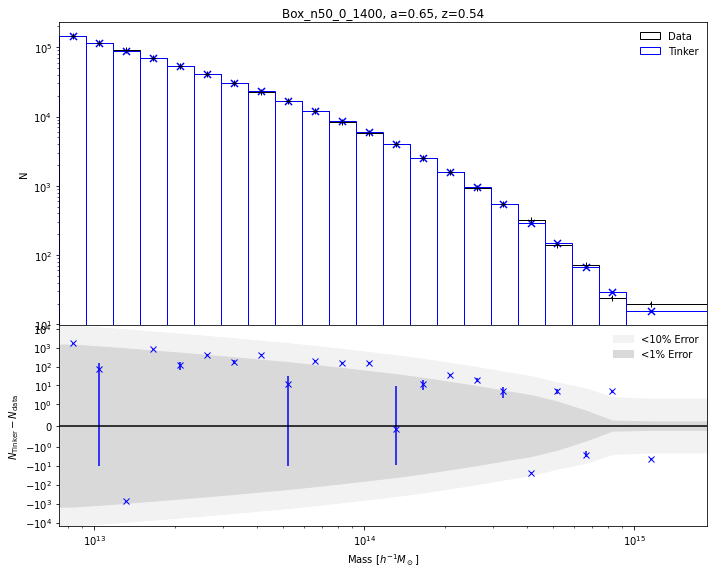

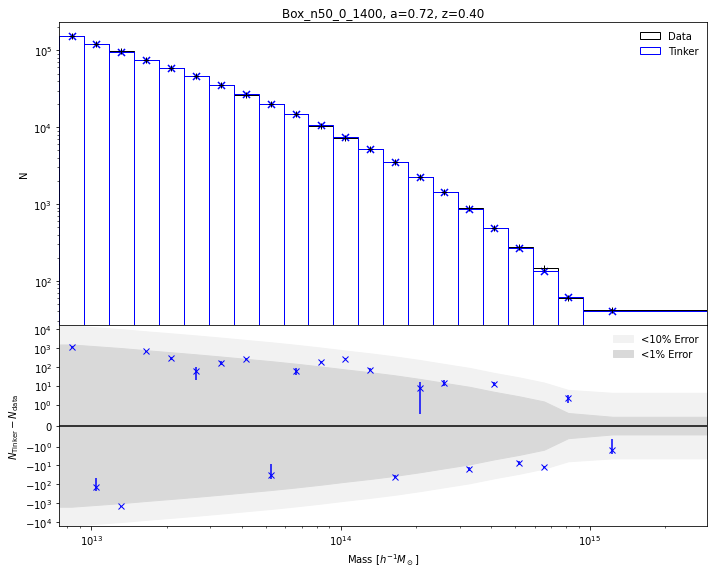

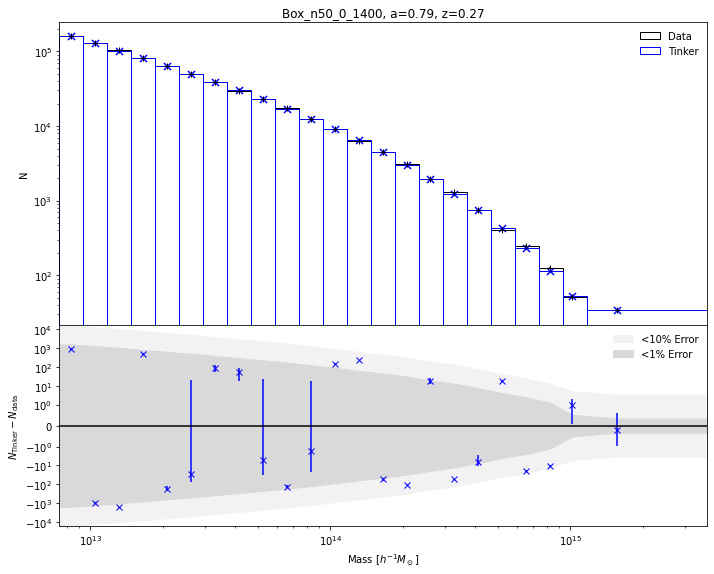

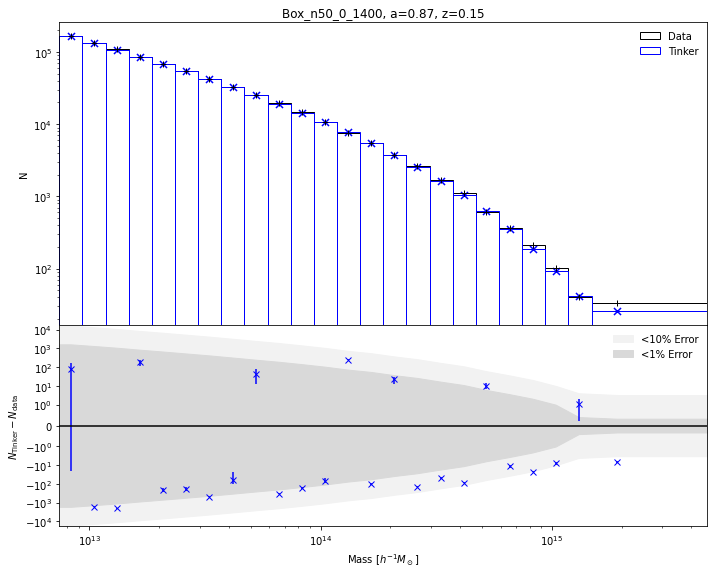

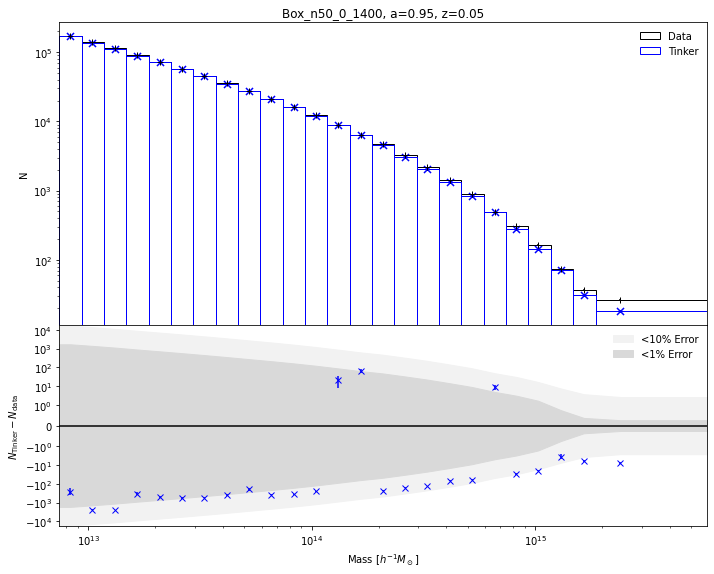

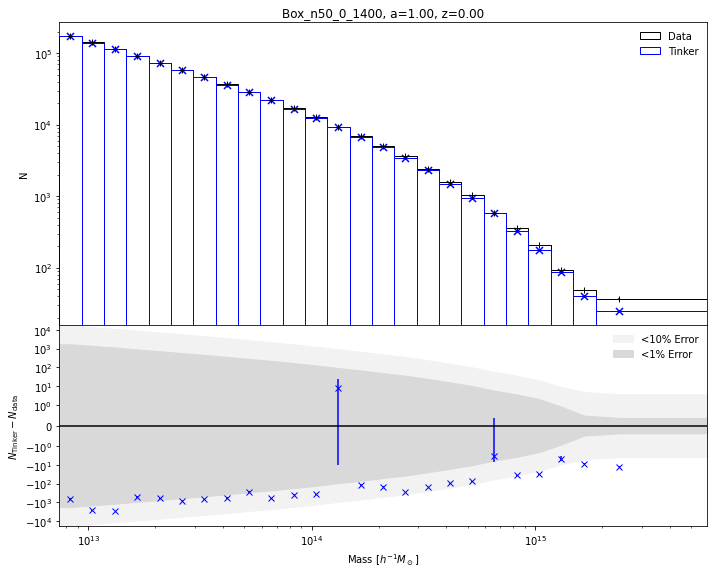

In [24]:
SUFFIX = ''
yerr_dict = {a:np.sqrt(np.diagonal(weighted_cov[a])) for a in weighted_cov} 
fig_axs = get_mass_function_plots(yerr_dict, params_final)
for (fig, a) in zip(fig_axs, N_data):
    fig_axs[fig][0].savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f%s.pdf'%(box, a, SUFFIX), bbox_inches='tight')

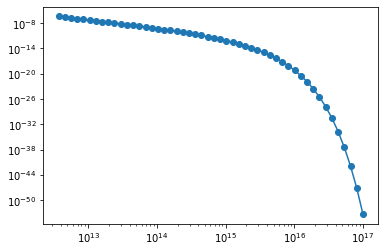

In [26]:
tinker_eval_MCMC = [tinker(a, M_c,**params_final,)*vol for M_c in M_numerics]
plt.scatter(M_numerics, tinker_eval_MCMC)
f_dndM_MCMC_LOG = interp1d(np.log10(M_numerics), tinker_eval_MCMC, kind='linear', bounds_error=False, fill_value=0.)
f_dndM_MCMC = lambda x:f_dndM_MCMC_LOG(np.log10(x))
plt.plot(M_numerics, f_dndM_MCMC(M_numerics))
plt.xscale('log')
plt.yscale('log')